**Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

Νίκος Κιοσσές

11/2024

###Εισαγωγή Βιβλιοθηκών

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init
from sklearn.decomposition import PCA

###Ορισμός παραμέτρων

In [17]:
batch_size = 50
num_classes = 10
learning_rate = 0.001
num_epochs = 50
#pca_n_components = 400
early_stop_patience = 3

###Κατέβασμα και προετοιμασία δεδομένων χωρίς PCA

**Προεπεξεργασία δεδομένων**

In [18]:
transform = transforms.Compose([

    # Τυχαία αναστροφή της εικόνας
    transforms.RandomHorizontalFlip(),

    # Αλλαγή στα χρώματα των εικόνων για ανίχνευση πολύπλοκων μοτίβο
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    # Προσθήκη τυχαίας περιστροφής
    transforms.RandomRotation(15),

    transforms.ToTensor(),

    # Κανονικοποίηση των τιμών των δειγμάτων με την μέση τιμή και την τυπική απόκλιση κάθε χρώματος. pixel = (pixel-mean[color]) / std[color]
    # CIFAR-10 mean[R,G,B] = [0.4914, 0.4822, 0.4465]
    # CIFAR-10 std[R,G,B] = [0.2023, 0.1994, 0.2010]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

**Κατέβασμα δεδομένων**

In [19]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


**Δημιουργία Dataloader**

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

###Κατέβασμα και προετοιμασία δεδομένων με PCA

**Προεπεξεργασία δεδομένων**

In [52]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

**Κατέβασμα δεδομένων**

In [53]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


KeyboardInterrupt: 

**Εφαρμογή PCA**

In [ ]:
# Προετοιμασία των δεδομένων για PCA
def flatten_dataset(dataset):
    data = []
    labels = []
    for img, label in dataset:
        img = img.view(-1).numpy()  # Επίπεδη εικόνα
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

# Μετατροπή δεδομένων εκπαίδευσης και δοκιμής σε επίπεδη μορφή
x_train, y_train = flatten_dataset(train_dataset)
x_test, y_test = flatten_dataset(test_dataset)

# Εφαρμογή PCA στα επίπεδα δεδομένα train_dataset και test_dataset
pca = PCA(n_components=pca_n_components)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

x_train = torch.Tensor(x_train)
y_train = torch.LongTensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.LongTensor(y_test)

**Δημιουργία Dataloader**

In [ ]:
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

###Κατασκευή του Νευρωνικού Δικτύου MLP

In [21]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Πρώτο hidden layer (2048 νευρώνες)
        #self.fc1 = nn.Linear(pca_n_components, 2048)
        self.fc1 = nn.Linear(32*32*3, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        # Δεύτερο hidden layer (1024 νευρώνες)
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        # Τρίτο hidden layer (512 νευρώνες)
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        # Τέταρτο hidden layer (256 νευρώνες)
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        # Output layer
        self.fc5 = nn.Linear(256, num_classes)

        # Dropout με πιθανότητα p=0.3 για το τέταρτο hidden layer
        self.dropout2 = nn.Dropout(p=0.3)
        # Activation Function: ReLU
        self.relu = nn.ReLU()
        # Αρχικοποίηση βαρών
        self.apply(self._initialize_weights)

    def forward(self, x):
        # Επίπεδη μορφή του input
        x = x.view(-1, 32 * 32 * 3)
        # Εφαρμογή του πρώτου hidden layer
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        # Εφαρμογή του δεύτερου hidden layer
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # Εφαρμογή του τρίτου hidden layer
        x = self.bn3(self.fc3(x))
        x = self.relu(x)
        # Εφαρμογή του τέταρτου hidden layer
        x = self.bn4(self.fc4(x))
        x = self.relu(x)
        x = self.dropout2(x)
        # Output layer
        x = self.fc5(x)
        return x

    # Αρχικοποίηση βαρών: He initialization
    def _initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)

**Αρχικοποίηση δικτύου, loss function και optimizer**

In [22]:
# Αρχικοποίηση μοντέλου
model = MLP()
# Loss Function: Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# Optimizer: συνάρτηση Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

###Εκπαίδευση του δικτύου

**Validation σε κάθε εποχή**

In [23]:
def validation(model, test_loader):
    model.eval()
    test_running_loss = 0.0

    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            max, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Τρέχον accuracy εποχής στο test set
        test_epoch_accuracy = accuracy_score(all_labels, all_predictions)
        test_accuracies.append(test_epoch_accuracy)

    # Μέσο test loss εποχής
    test_epoch_loss = test_running_loss / len(test_loader)

    return test_epoch_loss, test_epoch_accuracy

**Εκπαίδευση δικτύου**

In [24]:
# Ορισμός του scheduler για το learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Κρατάμε το accuracy στα δεδομένα του train set σε κάθε batch
train_accuracies = []
# Κρατάμε το accuracy στα δεδομένα του test set σε κάθε batch
test_accuracies = []

# Καλύτερο test loss μέχρι στιγμής
best_test_loss = 10
# Μετράει τις εποχές χωρίς βελτίωση
no_improvement_epochs = 0

start_time = time.time()

for epoch in range(num_epochs):
    train_running_loss = 0.0

    # Αρχικοποίηση της μπάρας προόδου σε κάθε εποχή
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    correct_preds = 0
    total_samples = 0
    for images, labels in progress_bar:
        # Forward pass
        outputs = model(images)
        # Υπολογισμός κόστους (loss)
        loss = criterion(outputs, labels)
        # Μηδενισμός των gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Ενημέρωση των βαρών βάσει των υπολογισμένων gradients
        optimizer.step()
        # Ανανέωση τρέχοντος κόστους εποχής
        train_running_loss += loss.item()

        # Υπολογισμός σωστών προβλέψεων στο train set για την εύρεση του batch accuracy
        max, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        # accuracy του batch στο train set
        train_batch_accuracy = correct_preds / total_samples

        # Ενημέρωση progress bar
        progress_bar.set_postfix(loss=train_running_loss / len(train_loader), accuracy=train_batch_accuracy)

    # accuracy εποχής στο train set
    train_epoch_accuracy = correct_preds / total_samples
    train_accuracies.append(train_epoch_accuracy)
    # Μέσο train loss εποχής
    train_epoch_loss = train_running_loss / len(train_loader)

    # accuracy εποχής στο test set και μέσο test loss εποχής
    test_epoch_loss, test_epoch_accuracy = validation(model, test_loader)

    # learning rate εποχής
    epoch_lr = optimizer.param_groups[0]['lr']

    print(f'Epoch [{epoch+1}/{num_epochs}]',
          f'Train Loss: {train_epoch_loss:.4f},',
          f'Test Loss: {test_epoch_loss:.4f},',
          f'Train Accuracy: {100 * train_epoch_accuracy:.2f}%,',
          f'Test Accuracy: {100 * test_epoch_accuracy:.2f}%,',
          f'Learning rate: {epoch_lr:.6f}')

    # Early stopping: Έλεγχος αν το test accuracy βελτιώθηκε
    if test_epoch_loss < best_test_loss:
        best_test_loss = test_epoch_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
    # Αν το test accuracy δεν έχει βελτιωθεί για 3 εποχές, τερματίζουμε την εκπαίδευση
    if no_improvement_epochs >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1} as test loss did not improve for {early_stop_patience} consecutive epochs.")
        break

    # Μείωση του learning rate κάθε φορά που το loss δεν βελτιώνεται πάνω από 0.02
    #if previous_loss is not None and (previous_loss - epoch_loss) <= 0.02:
        #scheduler.step()
    # Ενημέρωση του previous_loss για την επόμενη εποχή
    #previous_loss = epoch_loss

    # Ενημέρωση του learning rate
    scheduler.step()

end_time = time.time()
print()
print(f'Training time: {end_time - start_time:.2f} seconds')

Epoch 1/50: 100%|██████████| 1000/1000 [02:12<00:00,  7.56batch/s, accuracy=0.346, loss=1.83]


Epoch [1/50] Train Loss: 1.8331, Test Loss: 1.5945, Train Accuracy: 34.58%, Test Accuracy: 42.83%, Learning rate: 0.001000


Epoch 2/50: 100%|██████████| 1000/1000 [02:10<00:00,  7.66batch/s, accuracy=0.44, loss=1.56]


Epoch [2/50] Train Loss: 1.5645, Test Loss: 1.5328, Train Accuracy: 43.96%, Test Accuracy: 45.43%, Learning rate: 0.001000


Epoch 3/50: 100%|██████████| 1000/1000 [02:09<00:00,  7.70batch/s, accuracy=0.473, loss=1.48]


Epoch [3/50] Train Loss: 1.4798, Test Loss: 1.4569, Train Accuracy: 47.32%, Test Accuracy: 47.94%, Learning rate: 0.001000


Epoch 4/50: 100%|██████████| 1000/1000 [02:11<00:00,  7.62batch/s, accuracy=0.491, loss=1.43]


Epoch [4/50] Train Loss: 1.4259, Test Loss: 1.4219, Train Accuracy: 49.13%, Test Accuracy: 49.50%, Learning rate: 0.001000


Epoch 5/50: 100%|██████████| 1000/1000 [02:09<00:00,  7.70batch/s, accuracy=0.513, loss=1.37]


Epoch [5/50] Train Loss: 1.3699, Test Loss: 1.4186, Train Accuracy: 51.32%, Test Accuracy: 49.74%, Learning rate: 0.001000


Epoch 6/50: 100%|██████████| 1000/1000 [02:16<00:00,  7.33batch/s, accuracy=0.526, loss=1.33]


Epoch [6/50] Train Loss: 1.3281, Test Loss: 1.3655, Train Accuracy: 52.62%, Test Accuracy: 52.01%, Learning rate: 0.001000


Epoch 7/50: 100%|██████████| 1000/1000 [02:21<00:00,  7.07batch/s, accuracy=0.542, loss=1.29]


Epoch [7/50] Train Loss: 1.2863, Test Loss: 1.3516, Train Accuracy: 54.20%, Test Accuracy: 51.81%, Learning rate: 0.001000


Epoch 8/50: 100%|██████████| 1000/1000 [02:19<00:00,  7.14batch/s, accuracy=0.556, loss=1.24]


Epoch [8/50] Train Loss: 1.2387, Test Loss: 1.3429, Train Accuracy: 55.60%, Test Accuracy: 52.62%, Learning rate: 0.001000


Epoch 9/50: 100%|██████████| 1000/1000 [02:16<00:00,  7.34batch/s, accuracy=0.571, loss=1.2]


Epoch [9/50] Train Loss: 1.1998, Test Loss: 1.3185, Train Accuracy: 57.08%, Test Accuracy: 53.33%, Learning rate: 0.001000


Epoch 10/50: 100%|██████████| 1000/1000 [02:25<00:00,  6.89batch/s, accuracy=0.582, loss=1.16]


Epoch [10/50] Train Loss: 1.1642, Test Loss: 1.3249, Train Accuracy: 58.18%, Test Accuracy: 53.43%, Learning rate: 0.001000


Epoch 11/50: 100%|██████████| 1000/1000 [02:20<00:00,  7.13batch/s, accuracy=0.628, loss=1.04]


Epoch [11/50] Train Loss: 1.0385, Test Loss: 1.2712, Train Accuracy: 62.76%, Test Accuracy: 56.36%, Learning rate: 0.000500


Epoch 12/50: 100%|██████████| 1000/1000 [02:39<00:00,  6.28batch/s, accuracy=0.645, loss=0.987]


Epoch [12/50] Train Loss: 0.9870, Test Loss: 1.2776, Train Accuracy: 64.53%, Test Accuracy: 56.11%, Learning rate: 0.000500


Epoch 13/50: 100%|██████████| 1000/1000 [02:46<00:00,  6.02batch/s, accuracy=0.659, loss=0.945]


Epoch [13/50] Train Loss: 0.9447, Test Loss: 1.2765, Train Accuracy: 65.90%, Test Accuracy: 56.55%, Learning rate: 0.000500


Epoch 14/50: 100%|██████████| 1000/1000 [02:43<00:00,  6.12batch/s, accuracy=0.674, loss=0.902]


Epoch [14/50] Train Loss: 0.9022, Test Loss: 1.2862, Train Accuracy: 67.39%, Test Accuracy: 57.12%, Learning rate: 0.000500
Early stopping at epoch 14 as test loss did not improve for 3 consecutive epochs.

Training time: 2143.79 seconds


###Αξιολόγηση απόδοσης

**Αξιολόγηση στα δεδομένα του test set.**

In [25]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
      # Πρόβλεψη κλάσης
      outputs = model(images)

      # Υπολογίζουμε το μέγιστο κατά μήκος του άξονα των κλάσεων (axis 1), έτσι ώστε για κάθε εικόνα να επιστρέψει τη θέση της κλάσης με την υψηλότερη πιθανότητα.
      # Το predicted θα περιέχει έναν πίνακα με τους δείκτες (indices) της κλάσης με την υψηλότερη πιθανότητα για κάθε δείγμα του batch.
      max, predicted = torch.max(outputs.data, 1)

      # Προσθήκη των ετικετών, δηλαδή του y_test του κάθε δείγματος σε λίστα
      all_labels.extend(labels.cpu().numpy())
      # Προσθήκη των προβλέψεων, δηλαδή του y_pred σε λίστα
      all_predictions.extend(predicted.cpu().numpy())

# Υπολογισμός μετρικών
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 56.96%
Precision: 57.21%
Recall: 56.96%
F1 Score: 57.02%


**Αξιολόγηση στα δεδομένα του train set.**

In [26]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in train_loader:
      # Πρόβλεψη κλάσης
      outputs = model(images)

      # Υπολογίζουμε το μέγιστο κατά μήκος του άξονα των κλάσεων (axis 1), έτσι ώστε για κάθε εικόνα να επιστρέψει τη θέση της κλάσης με την υψηλότερη πιθανότητα.
      # Το predicted θα περιέχει έναν πίνακα με τους δείκτες (indices) της κλάσης με την υψηλότερη πιθανότητα για κάθε δείγμα του batch.
      max, predicted = torch.max(outputs.data, 1)

      # Προσθήκη των ετικετών, δηλαδή του y_train του κάθε δείγματος σε λίστα
      all_labels.extend(labels.cpu().numpy())
      # Προσθήκη των προβλέψεων, δηλαδή του y_pred σε λίστα
      all_predictions.extend(predicted.cpu().numpy())

# Υπολογισμός μετρικών
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 70.31%
Precision: 70.42%
Recall: 70.31%
F1 Score: 70.32%


**Γράφημα accuracy ανά εποχή**

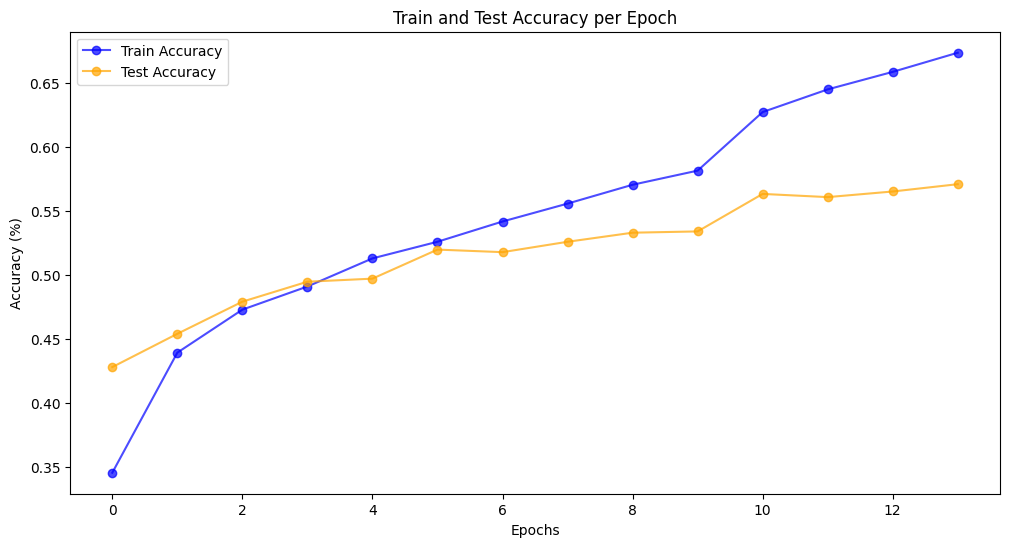

In [27]:
# Απεικόνιση γραφήματος για το train και test accuracy ανά εποχή
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy', color='blue', alpha=0.7, marker='o')
plt.plot(test_accuracies, label='Test Accuracy', color='orange', alpha=0.7, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy per Epoch')
plt.legend()
plt.show()